
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 脱落

:label: `sec_dropout`

優れた予測モデルに何を期待するかについて簡単に考えてみましょう。目に見えないデータでも適切に動作するようにしたいと考えています。古典的な一般化理論では、トレーニングとテストのパフォーマンス間のギャップを埋めるには、単純なモデルを目指すべきであると示唆しています。シンプルさは、少数の次元の形でもたらされます。 :numref: `sec_generalization_basics`で線形モデルの単項基底関数を議論する際に、これについて検討しました。さらに、 :numref: `sec_weight_decay`で重み減衰 ($\ell_2$ 正則化) について説明したときに見たように、パラメーターの (逆) ノルムも単純さの有用な尺度を表します。単純さに関するもう 1 つの有用な概念は、滑らかさです。つまり、関数は入力の小さな変化に敏感であるべきではありません。たとえば、画像を分類する場合、ピクセルにランダムなノイズを追加してもほとんど無害であると予想されます。

 1995 年に、Christopher Bishop は、入力ノイズを使用したトレーニングが Tikhonov 正則化と同等であることを証明し、このアイデアを正式にしました :cite: `Bishop.1995` 。この研究は、関数が滑らかである (したがって単純である) という要件と、入力の摂動に対する耐性があるという要件との間の明確な数学的関係を描きました。

その後、2014 年に、:citet: `Srivastava.Hinton.Krizhevsky.ea.2014`が、ビショップのアイデアをネットワークの内部層にも適用する方法についての賢明なアイデアを開発しました。*ドロップアウト*と呼ばれる彼らのアイデアには、順伝播中に各内部層を計算する際にノイズを注入することが含まれており、これはニューラル ネットワークをトレーニングするための標準的な手法となっています。この方法は、文字通りトレーニング中にいくつかのニューロンを*ドロップアウトする*ため、*ドロップアウト*と呼ばれます。トレーニング全体を通じて、反復ごとに、標準ドロップアウトは、後続の層を計算する前に各層のノードの一部をゼロにすることで構成されます。

明確にしておきますが、私たちはビショップとのつながりを持った独自の物語を押し付けています。ドロップアウトに関する元の論文は、有性生殖への驚くべき類似性を通じて直観を提供します。著者らは、ニューラル ネットワークの過学習は、各層が前の層の特定の活性化パターンに依存する状態によって特徴付けられ、この状態を*共適応 と*呼んでいると主張しています。彼らは、有性生殖が共適応遺伝子を破壊すると主張されているのと同じように、ドロップアウトは共適応を破壊すると主張する。この理論の説明には確かに議論の余地がありますが、ドロップアウト手法自体は永続的なことが証明されており、さまざまな形式のドロップアウトがほとんどの深層学習ライブラリに実装されています。

重要な課題は、このノイズをどのように注入するかです。 1 つのアイデアは、各層の期待値が、他の層を固定しながら、ノイズが存在しない場合に取られる値と等しくなるように、*バイアスのない*方法でノイズを注入することです。ビショップの研究では、線形モデルへの入力にガウス ノイズを追加しました。各トレーニング反復で、平均ゼロの分布からサンプリングされたノイズ $\epsilon \sim \mathcal{N}(0,\sigma^2)$ を入力 $\mathbf{x}$ に追加し、摂動点 $ を生成しました。 \mathbf{x}&#39; = \mathbf{x} + \epsilon$。予想では、$E[\mathbf{x}&#39;] = \mathbf{x}$ となります。

標準的なドロップアウト正則化では、各層のノードの一部をゼロにしてから、保持された (ドロップアウトされなかった) ノードの割合で正規化することで各層のバイアス*を軽減します*。言い換えると、*ドロップアウト確率*$p$ を使用すると、次のように各中間活性化 $h$ が確率変数 $h&#39;$ に置き換えられます。

 $$ \begin{aligned} h&#39; = \begin{cases} 0 &amp; \text{ 確率付き } p \ \frac{h}{1-p} &amp; \text{ それ以外の場合} \end{cases} \end{aligned } $$

設計上、期待値は変更されません。つまり、$E[h&#39;] = h$ となります。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## 練習中ドロップアウト

:numref: `fig_mlp`に隠れ層と 5 つの隠れユニットがある MLP を思い出してください。ドロップアウトを隠れ層に適用し、確率 $p$ で各隠れユニットをゼロにすると、結果は元のニューロンのサブセットのみを含むネットワークとして見ることができます。 :numref: `fig_dropout2`では、 $h_2$ と $h_5$ が削除されます。その結果、出力の計算は $h_2$ または $h_5$ に依存しなくなり、逆伝播を実行するとそれぞれの勾配もなくなります。このようにして、出力層の計算は、$h_1、\ldots、h_5$ のいずれかの要素に過度に依存することはできません。

![](http://d2l.ai/_images/dropout2.svg) :ラベル: `fig_dropout2`

通常、テスト時にはドロップアウトを無効にします。トレーニングされたモデルと新しい例が与えられた場合、どのノードもドロップアウトしないため、正規化する必要はありません。ただし、例外もいくつかあります。一部の研究者は、ニューラル ネットワーク予測の*不確実性を*推定するためのヒューリスティックとして、テスト時にドロップアウトを使用します。予測が多くの異なるドロップアウト マスクにわたって一致する場合、ネットワークはより信頼できると言えるでしょう。

## ゼロからの実装

単一層のドロップアウト関数を実装するには、層の次元と同じだけ多くのサンプルをベルヌーイ (バイナリ) 確率変数から抽出する必要があります。ここで、確率変数は、確率 $1-p$ および $0$ で値 $1$ (keep) をとります。 (ドロップ) 確率 $p$。これを実装する簡単な方法の 1 つは、まず一様分布 $U[0, 1]$ からサンプルを抽出することです。次に、対応するサンプルが $p$ より大きいノードを保持し、残りを削除します。

次のコードでは、(**確率ドロップ`dropout`でテンソル入力`X`の要素をドロップアウトする`dropout_layer`関数を実装し**)、上記のように残りを再スケーリングします: 生存者を`1.0-dropout`で除算します。


In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)


[**いくつかの例で`dropout_layer`関数をテストする**]ことができます。次のコード行では、入力`X`それぞれ確率 0、0.5、1 でドロップアウト操作に渡します。


In [3]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  2.,  4.,  0.,  8.,  0.,  0.,  0.],
        [16., 18.,  0.,  0., 24., 26., 28.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])



### モデルの定義

以下のモデルは、各隠れ層の出力にドロップアウトを適用します (活性化関数に従います)。各レイヤーのドロップアウト確率を個別に設定できます。一般的な傾向は、入力層に近いほどドロップアウト確率を低く設定することです。ドロップアウトがトレーニング中にのみアクティブになることを保証します。


In [4]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)


### 【**トレーニング**】

以下は、前述した MLP のトレーニングと似ています。


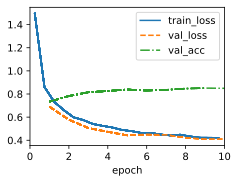

In [5]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


## [**簡潔な実装**]

高レベル API を使用する場合、必要なのは、完全に接続された各層の後に`Dropout`層を追加し、ドロップアウト確率を唯一の引数としてコンストラクターに渡すことだけです。トレーニング中に、 `Dropout`層は、指定されたドロップアウト確率に従って、前の層の出力 (または同等に、後続の層への入力) をランダムにドロップアウトします。トレーニング モードではない場合、 `Dropout`層はテスト中にデータを単に通過させます。


In [6]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))


次に、[**モデルをトレーニング**]します。


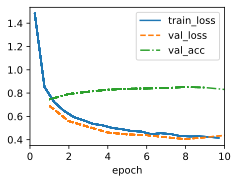

In [7]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)


## まとめ

次元数と重みベクトルのサイズを制御するだけでなく、ドロップアウトは過学習を回避するためのもう 1 つのツールです。併用して使われることも多いです。ドロップアウトはトレーニング中にのみ使用されることに注意してください。ドロップアウトは、活性化 $h$ を期待値 $h$ を持つ確率変数に置き換えます。

## 演習
1. 1 層目と 2 層目のドロップアウト確率を変更するとどうなるでしょうか?特に、両方のレイヤーのものを切り替えるとどうなりますか?これらの質問に答えるための実験を計画し、結果を定量的に説明し、定性的なポイントを要約します。
1. エポック数を増やし、ドロップアウトを使用した場合に得られた結果と、ドロップアウトを使用しなかった場合の結果を比較します。
1. ドロップアウトが適用される場合と適用されない場合の、各隠れ層のアクティベーションの分散はどれくらいですか?プロットを描いて、両方のモデルでこの量が時間の経過とともにどのように変化するかを示します。
1. 通常、テスト時にドロップアウトが使用されないのはなぜですか?
1. このセクションのモデルを例として使用して、ドロップアウトとウェイト減衰を使用した場合の効果を比較します。ドロップアウトとウェイト減衰を同時に使用するとどうなりますか?結果は相加的ですか?収益の減少（またはそれ以上）はありますか?それらは互いに打ち消し合うのでしょうか？
1. アクティベーションではなく重み行列の個々の重みにドロップアウトを適用するとどうなるでしょうか?
1. 標準的なドロップアウト手法とは異なる、各層にランダム ノイズを注入するための別の手法を発明します。 Fashion-MNIST データセット (固定アーキテクチャの場合) でドロップアウトよりも優れたパフォーマンスを発揮するメソッドを開発できますか?



[ディスカッション](https://discuss.d2l.ai/t/101)
